### Exercise 2: Learning a Language Model from scratch 
Learn a Language Model from the text ["metamorphosis.txt"](https://drive.google.com/file/d/1ip_8SZt0eYqkQMivtbTfnNiEqImtJS2t/view?usp=sharing) (dataset of notebook of day 1) and generate text with it. 
1. Preprocess your dataset for your needs (split into sentences, tokenize, clean text, build vocabulary, encode sentences)
2. Create tensorflow datasets and dataloader from the processed datasets 
3. Build a RNN Language Model (see [notebook of day #3](https://colab.research.google.com/drive/1M_KpWjtcOrFZ_Ng8qUPHB0XTAZVWGCwE?usp=sharing)) and train it 
4. Compute its perplexity over the test set: can we obtain a perplexity around or inferior to 3 in the validation set ?
5. Generate text with it using nucleus sampling (or top-k nucleus sampling): See this chunk of code as an help to implement the method: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
and print the generated text.
6. Bonus Question: Take a random sentence of the test dataset, generate text with the trained language model, and compare it with text generated with GPT-2. 
See hugging face tutorial: https://huggingface.co/blog/how-to-generate


In [2]:
# MAIN IMPORTS
import re # Regular Expression. 
import nltk # text preprocessing 
import gensim # Load Word2vec and GloVe
import string
import matplotlib.pyplot as plt
import numpy as np
# download data from the library
nltk.download('punkt')
nltk.download('stopwords')

import pandas as pd
import tensorflow as tf
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# read text file
filename = '/content/drive/MyDrive/metamorphosis.txt'
file = open(filename, 'rt')
text = file.read()
file.close()

In [4]:
# split into sentences
from nltk import sent_tokenize
sentences = sent_tokenize(text)
print("number of sentences", len(sentences))
for i in range(10):
  print(sentences[i])
  print("-"*60)

number of sentences 797
One morning, when Gregor Samsa woke from troubled dreams, he found
himself transformed in his bed into a horrible vermin.
------------------------------------------------------------
He lay on
his armour-like back, and if he lifted his head a little he could
see his brown belly, slightly domed and divided by arches into stiff
sections.
------------------------------------------------------------
The bedding was hardly able to cover it and seemed ready
to slide off any moment.
------------------------------------------------------------
His many legs, pitifully thin compared
with the size of the rest of him, waved about helplessly as he
looked.
------------------------------------------------------------
"What's happened to me?"
------------------------------------------------------------
he thought.
------------------------------------------------------------
It wasn't a dream.
------------------------------------------------------------
His room,
a proper human

In [6]:
# create df for easy manips 
df = pd.DataFrame()
df['sentence'] = sentences
# split sentence for test settings ()
get_sen_1 = lambda x: ' '.join(x.split()[:int(len(x.split())/2)])
get_sen_2 = lambda x:' '.join(x.split()[int(len(x.split())/2):])
df['sentence_1'] = df.sentence.apply(get_sen_1)
df['sentence_2'] = df.sentence.apply(get_sen_2)
df.head()

,sentence,sentence_1,sentence_2
0,"One morning, when Gregor Samsa woke from troub...","One morning, when Gregor Samsa woke from troub...",found himself transformed in his bed into a ho...
1,"He lay on\nhis armour-like back, and if he lif...","He lay on his armour-like back, and if he lift...","he could see his brown belly, slightly domed a..."
2,The bedding was hardly able to cover it and se...,The bedding was hardly able to cover it,and seemed ready to slide off any moment.
3,"His many legs, pitifully thin compared\nwith t...","His many legs, pitifully thin compared with th...","the rest of him, waved about helplessly as he ..."
4,"""What's happened to me?""","""What's happened","to me?"""


In [11]:
# print sentences example:
print(sentences[0])
print(sentences[np.random.randint(len(sentences))])

One morning, when Gregor Samsa woke from troubled dreams, he found
himself transformed in his bed into a horrible vermin.
Were all employees, every
one of them, louts, was there not one of them who was faithful and
devoted who would go so mad with pangs of conscience that he
couldn't get out of bed if he didn't spend at least a couple of
hours in the morning on company business?


In [33]:
def clean_text(sentences):
    clean_func1 = lambda t: ' '.join(t.split("-")) # .replace("-", " ")
    clean_func2 = lambda t: ' '.join(re.split(r"([0-9]+)([a-z]+)", t, flags=re.I)) # "9st" => "9 st" 
    clean_func3 = lambda t: ' '.join(re.split(r"([a-z]+)([0-9]+)", t, flags=re.I))
    clean_func4 = lambda t: t.lower().replace("&", "and")
    sentences = sentences.apply(clean_func1)
    sentences = sentences.apply(clean_func2)
    sentences = sentences.apply(clean_func3)
    sentences = sentences.apply(clean_func4)
    return sentences

In [34]:
from nltk.tokenize import word_tokenize
def get_vocab(sentences, tokens_to_remove=["$", "%", "'", "''"], special_tokens=["<PAD>", "<SOS>", "<EOS>"]):
    print("Building vocab....")
    # tokenize sentences
    tokenized_sentences = sentences.apply(word_tokenize)
    tokenized_sentences = tokenized_sentences.values # nested list 
    tokens = [w for s in tokenized_sentences for w in s] # flatten list 

    # build vocab
    unique_tokens = list(set(tokens))
    unique_tokens = [token for token in unique_tokens if token not in tokens_to_remove ]

    unique_tokens.sort()
    vocab = {v: k for k, v in enumerate(special_tokens + unique_tokens)}
    print("vocab length:", len(vocab))
    print("saving vocab...")
    with open("vocab.json", "w") as f:
        json.dump(vocab, f)
    return tokens, vocab


def tokenize(sentences, vocab):
    # tokenize sentences with vocab
    # add <SOS> and <EOS> at beginning and end of sentence
    # splitter input data, target data (shifted sentence)
    # pad sequences to have same length 
    tok_func = lambda t: [vocab["<SOS>"]] + [vocab[w] for w in t if w in vocab.keys()]+[vocab["<EOS>"]]
    tokens_id = sentences.apply(word_tokenize)
    tokens_id = tokens_id.apply(tok_func)
    df = pd.DataFrame()
    df['input_sentence'] = tokens_id.apply(lambda t: t[:-1])
    df['target_sentence'] = tokens_id.apply(lambda t: t[1:])
    len_sentences = tokens_id.apply(len)
    max_len = np.max(len_sentences)
    pad_func = lambda t: t + [0] * (max_len - len(t))
    df["input_sentence"] = df.input_sentence.apply(pad_func)
    df["target_sentence"] = df.target_sentence.apply(pad_func)
    return df, max_len

def tokenize_test(sentences, vocab):
    tokenize_func = lambda t: word_tokenize(t)
    tok_to_id_func = lambda t: [vocab["<SOS>"]]+[vocab[w] for w in t if w in vocab.keys()]+[vocab["<EOS>"]]
    tokenized_sentences = sentences.apply(tokenize_func)
    tokens_id = tokenized_sentences.apply(tok_to_id_func)
    len_sentences = tokens_id.apply(len)
    return tokens_id, len_sentences

def split_train_test(sentences, sentences_1_and_2, val_size=100, test_size=200):
    train_size = len(sentences) - (val_size + test_size)
    train_sentences = sentences[:train_size]
    val_sentences = sentences[train_size:train_size + val_size]
    test_sentences = sentences_1_and_2[train_size + val_size:train_size + val_size + test_size]
    return train_sentences, val_sentences, test_sentences

def preprocess_data(df):
    # get data 
    sentences, sentences_1, sentences_2 = df.sentence , df.sentence_1 , df.sentence_2
    sentences, sentences_1, sentences_2 = clean_text(sentences), clean_text(sentences_1), clean_text(sentences_2) # text cleaning
    tokens, vocab = get_vocab(sentences) # Build vocab 
    padded_sentences, max_len = tokenize(sentences, vocab) # tokenize, split input/target, pad sequences
    print("dataset set length:", len(padded_sentences))
    sentences_1, len_sentences_1 = tokenize_test(sentences_1, vocab)
    sentences_2, len_sentences_2 = tokenize_test(sentences_2, vocab)
    sentences_1_and_2 = pd.concat([sentences_1, sentences_2], axis=1) # dataframe with 2 sentences 
    train_sentences, val_sentences, test_sentences = split_train_test(padded_sentences, sentences_1_and_2)
    print("train dataset size", len(train_sentences))
    print("val dataset size", len(val_sentences))
    print("test dataset size", len(test_sentences))
    return train_sentences, val_sentences, test_sentences

train_sentences, val_sentences, test_sentences = preprocess_data(df)

Building vocab....
vocab length: 2592
saving vocab...
dataset set length: 797
train dataset size 497
val dataset size 100
test dataset size 200


In [54]:
def get_dataloader(dataset,  batch_size):
    # transform 2 columns of dataframe to numpy arrays
    input_sentence = np.array([seq for seq in dataset.input_sentence.values])
    target_sentence = np.array([seq for seq in dataset.target_sentence.values])
    # tensorflow dataset
    tfdataset = tf.data.Dataset.from_tensor_slices(
            (input_sentence, target_sentence))
    # tensorflow dataloader
    dataloader = tfdataset.batch(batch_size, drop_remainder=True)
    return dataloader

def get_test_dataloader(data):
    inputs, targets = data.sentence_1, data.sentence_2
    inputs = inputs.to_list()
    targets = targets.to_list()
    inputs = [tf.constant(inp, dtype=tf.int32) for inp in inputs]
    targets = [tf.constant(tar, dtype=tf.int32) for tar in targets]
    return (inputs, targets)

In [55]:
batch_size = 16
train_loader = get_dataloader(train_sentences, batch_size=batch_size)
print(next(iter(train_loader)))
val_loader = get_dataloader(val_sentences, batch_size=batch_size)
print(next(iter(val_loader)))
test_loader = get_test_dataloader(test_sentences)
inputs_test, targets_test = test_loader
print(inputs[0])
print(targets[0])

(<tf.Tensor: shape=(16, 161), dtype=int64, numpy=
array([[   1, 1553, 1448, ...,    0,    0,    0],
       [   1, 1049, 1283, ...,    0,    0,    0],
       [   1, 2258,  205, ...,    0,    0,    0],
       ...,
       [   1, 1117, 1035, ...,    0,    0,    0],
       [   1, 1049, 1469, ...,    0,    0,    0],
       [   1,   19, 1549, ...,    0,    0,    0]])>, <tf.Tensor: shape=(16, 161), dtype=int64, numpy=
array([[1553, 1448,   13, ...,    0,    0,    0],
       [1049, 1283, 1551, ...,    0,    0,    0],
       [2258,  205, 2475, ...,    0,    0,    0],
       ...,
       [1117, 1035, 1049, ...,    0,    0,    0],
       [1049, 1469, 1046, ...,    0,    0,    0],
       [  19, 1549,   13, ...,    0,    0,    0]])>)
(<tf.Tensor: shape=(16, 161), dtype=int64, numpy=
array([[   1, 1004,  993, ...,    0,    0,    0],
       [   1,   19, 1239, ...,    0,    0,    0],
       [   1, 1218, 2475, ...,    0,    0,    0],
       ...,
       [   1, 1049, 1711, ...,    0,    0,    0],
       [ 

In [56]:
def decode(seq_idx, vocab, delim=' ', ignored=["<SOS>", "<PAD>"], stop_at_end=True):
  # inv vocab
  inv_vocab = {token_id: token for token, token_id in vocab.items()}
  decoded_sentence = []
  # decode sent
  for token_id in seq_idx:
    if stop_at_end:
      if inv_vocab[token_id] == "<EOS>":
        break
    if inv_vocab[token_id] not in ignored:
      decoded_sentence.append(inv_vocab[token_id])

  # join tokens
  return delim.join(decoded_sentence)
decode(inputs[0].numpy(), vocab)

'one morning , when gregor samsa woke from troubled dreams , he found himself transformed in his bed into a horrible vermin .'

In [57]:
# Build Model
def build_RNN(vocab_size, emb_size, output_size, rnn_units, dropout_rate, rnn_drop_rate=0.0):
  model = tf.keras.Sequential()
  e = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=emb_size, mask_zero=True)
  model.add(e)
  lstm = tf.keras.layers.GRU(units=rnn_units, recurrent_dropout=rnn_drop_rate, return_sequences=True) # to output each hidden representation of the sequence
  model.add(lstm)
  model.add(tf.keras.layers.Dropout(dropout_rate))
  model.add(tf.keras.layers.Dense(output_size)) # we compute only logits. 
  return model

In [58]:
rnn_model = build_RNN(vocab_size=len(vocab), emb_size=32, output_size=len(vocab), rnn_units=64, dropout_rate=0.1)
lr = 0.001
optimizer = tf.keras.optimizers.Adam(lr,
                                                  beta_1=0.9,
                                                  beta_2=0.98,
                                                  epsilon=1e-9)
EPOCHS = 20 # 10 for debugging. generally, in Language modelling, we take between 30 and 50 epochs. 

In [59]:
# test past forward on the lstm
for (inputs, targets) in train_loader.take(1):
    preds = lstm_model(inputs)
print(preds.shape)

(16, 161, 2592)


In [60]:
def train_RNN(model, optimizer, EPOCHS, train_dataset, val_dataset, checkpoint_path):
    LSTM_ckpt_path = checkpoint_path + '/' + 'LSTM-{epoch}'

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=LSTM_ckpt_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)
    ]
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

    print(model.summary())

    # Save the weights using the `checkpoint_path` format
    #model.save_weights(checkpoint_path.format(epoch=0))

    # --- starting the training ... -----------------------------------------------
    start_training = time.time()
    rnn_history = model.fit(train_dataset,
                            epochs=EPOCHS,
                            validation_data=val_dataset,
                            callbacks=callbacks,
                            verbose=2)

    train_loss_history_rnn = rnn_history.history['loss']
    val_loss_history_rnn = rnn_history.history['val_loss']
    train_ppl_history = np.exp(train_loss_history_rnn)
    val_ppl_history = np.exp(val_loss_history_rnn)
    train_history = [train_loss_history_rnn, val_loss_history_rnn, train_ppl_history, val_ppl_history]

    print('Training time for {} epochs: {}'.format(EPOCHS, time.time() - start_training))

    return train_history # [list_train_loss, list_val_loss, list_train_perplexity, list_val_perplexity]

In [61]:
import os
import time
checkpoint_path = "/checkpoints"
if not os.path.isdir(checkpoint_path):
  os.makedirs(checkpoint_path)
train_history = train_RNN(model=rnn_model, optimizer=optimizer, EPOCHS=EPOCHS, train_dataset=train_loader, val_dataset=val_loader, checkpoint_path=checkpoint_path)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          82944     
                                                                 
 gru (GRU)                   (None, None, 64)          18816     
                                                                 
 dropout_1 (Dropout)         (None, None, 64)          0         
                                                                 
 dense_1 (Dense)             (None, None, 2592)        168480    
                                                                 
Total params: 270,240
Trainable params: 270,240
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20

Epoch 00001: val_loss improved from inf to 1.76781, saving model to /checkpoints/LSTM-1
31/31 - 11s - loss: 1.5187 - val_loss: 1.7678 - 11s/epoch - 344ms/step
Epoc

In [62]:
def plot_train_history(train_history):
    fig, axs = plt.subplots(1,2, figsize=(30,15))
    train_loss_history = train_history[0]
    val_loss_history = train_history[1]
    train_ppls = train_history[2]
    val_ppls = train_history[-1]
    axs[0].plot(train_loss_history)
    axs[0].plot(val_loss_history)
    axs[1].plot(train_ppls)
    axs[1].plot(val_ppls)
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[1].set_ylabel("Perplexity")
    axs[0].legend(["train_loss", "val_loss"])
    axs[1].legend(["train_ppl", "val_ppl"])
    plt.show()

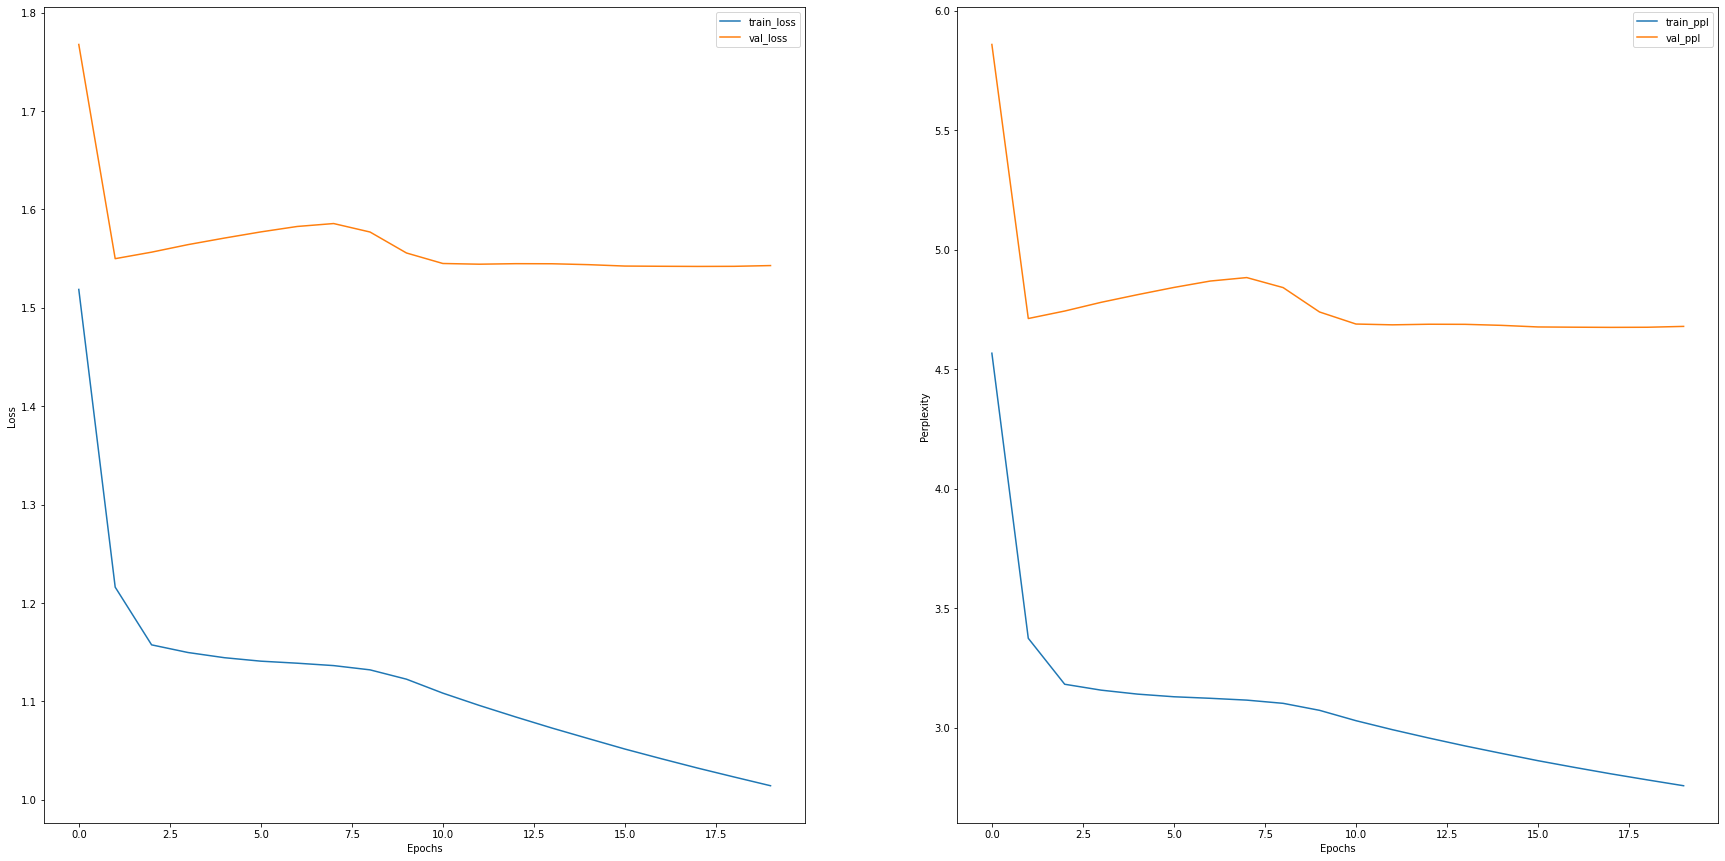

In [63]:
plot_train_history(train_history)

In [64]:
def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: logits distribution shape (vocabulary size)
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            top_p >0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
    """
    

    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < tf.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    if top_p > 0.0:
        sorted_logits = tf.sort(logits,direction='DESCENDING')
        sorted_indices = tf.argsort(logits,direction='DESCENDING')
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

        # Remove tokens with cumulative probability above the threshold
        sorted_indices_to_remove = cumulative_probs > top_p

        # to numpy 
        sorted_indices_to_remove = sorted_indices_to_remove.numpy()
        # Shift the indices to the right to keep also the first token above the threshold
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].copy()
        sorted_indices_to_remove[..., 0] = 0

        indices_to_remove = sorted_indices[sorted_indices_to_remove]
    
        idx_to_remove = [int(i) for i in indices_to_remove.numpy()]
        logits_np = logits.numpy()
        logits_np[idx_to_remove] = filter_value
    return tf.convert_to_tensor(logits_np)

inputs_sample = inputs_test[1]

# Here is how to use this function for top-p sampling
temperature = 1.0
top_k = 0
top_p = 0.9

# Get logits with a forward pass in our model (input is pre-defined)
logits = rnn_model(inputs=inputs, training=False)
# Keep only the last token predictions of the first batch item (batch size 1), apply a temperature coefficient and filter
logits = logits[0, -1, :] / temperature
filtered_logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)

# Sample from the filtered distribution
probabilities = tf.nn.softmax(filtered_logits, axis=-1)
probabilities = tf.reshape(probabilities,(1,-1))
last_pred = tf.random.categorical(logits=probabilities, num_samples=1, dtype=tf.int32)
last_pred = tf.reshape(last_pred, shape=(last_pred.shape[-1], last_pred.shape[0]))
last_pred

<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[99]], dtype=int32)>

In [65]:
def generate_text(model, inputs, seq_len=10,temperature = 1.0 , top_k = 0 , top_p = 0.9):
  # Loop over number of decoding timesteps: (equal to seq_len)
  for t in range(seq_len):
      # pass forward on the model 
      preds_test = model(inputs=inputs, training=False)  # logits (B,S,V)
      # get the last prediction (logits)
      preds_test = preds_test[0, -1, :] / temperature
      filtered_logits = top_k_top_p_filtering(preds_test, top_k=top_k, top_p=top_p)
      # Sample from the filtered distribution
      probabilities = tf.nn.softmax(filtered_logits, axis=-1)
      probabilities = tf.reshape(probabilities,(1,-1))
      last_pred = tf.random.categorical(logits=probabilities, num_samples=1, dtype=tf.int32)
      last_pred = tf.reshape(last_pred, shape=(last_pred.shape[-1], last_pred.shape[0]))
      inputs = tf.concat([inputs, last_pred], axis=1)
  # return the final inputs (complete sequence of word ids)
  return inputs, inputs[:,-seq_len:]

In [66]:
import pprint
inputs_test, targets_test = test_loader # inputs = sentence1, targets=sentence2
inputs_sample = inputs_test[1]
pprint.pprint("input sentence : ")
pprint.pprint( decode(inputs_sample.numpy(), vocab))

inputs_sample = inputs_sample[tf.newaxis,:] # shape (1,16)

encoded_text, encoded_preds = generate_text(rnn_model, inputs_sample,)
pprint.pprint("generated text")

pprint.pprint( decode(tf.squeeze(encoded_text).numpy(), vocab, stop_at_end=False))
#print("generated sentence", decode(tf.squeeze(encoded_preds).numpy(), vocab, stop_at_end=False))

'input sentence : '
('one time , though , the charwoman left the door to the living room slightly '
 'open , and it remained open')
'generated text'
('one time , though , the charwoman left the door to the living room slightly '
 'open , and it remained open <EOS> premises wealth working aggrieved stepped '
 'both appeared believing ancient months')
